# Calibrating qubits using Qiskit Pulse

This is a notebook corresponding to the report "On IBM Q OpenPulse." The experiments are very similar to [the qiskit online textbook](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-openpulse.html). It is only shorter and has some of the parameters adjusted for ibmq_johannesburg. For more expalantion, please refer to the online textbook.

In [1]:
from qiskit.tools.jupyter import *
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')
backend = provider.get_backend('ibmq_johannesburg')

In [2]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

In [3]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


In [4]:
backend_defaults = backend.defaults()

# Part 1
## 1. Finding the qubit frequency using a frequency sweep

In [5]:
import numpy as np

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release

print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.664860920595558 GHz.
The sweep will go from 4.644860920595558 GHz to 4.6848609205955585 GHz in steps of 1.0 MHz.


In [6]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [7]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import pulse_lib  # This Pulse module helps us build sampled pulses for common pulse shapes


# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
drive_amp = 0.3
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

In [8]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [9]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

In [10]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

In [11]:
# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Frequency sweep')
schedule += drive_pulse(drive_chan)
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
schedule += measure << schedule.duration

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]

/home/maziar/anaconda3/envs/Qiskitenv/lib/python3.7/site-packages/qiskit/pulse/pulse_lib/sample_pulse.py:152: DeprecationWarning: Calling `SamplePulse` with a channel is deprecated. Instantiate the new `Play` instruction directly with a pulse and a channel. In this case, please use: `Play(SamplePulse(samples), DriveChannel(0))`.
  DeprecationWarning)


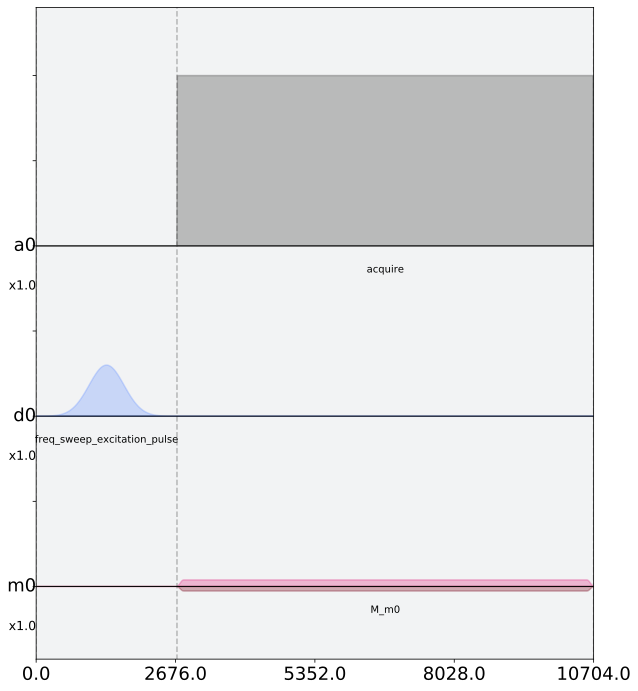

In [12]:
schedule.draw(channels=[drive_chan, meas_chan, acq_chan], label=True, scaling=1.0)

In [13]:
from qiskit import assemble

num_shots_per_frequency = 1024
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

In [30]:
job = backend.run(frequency_sweep_program)

In [31]:
# print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


In [32]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds

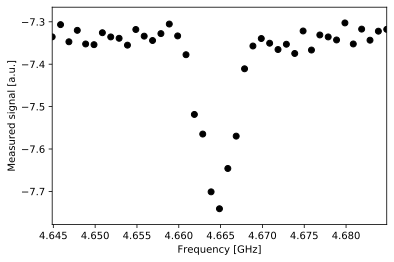

In [125]:
%matplotlib inline
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [143]:
#I want to repeat this 10 times to get an estimate on the error bars. 


job_ids=[]
job_results=[]
for i in range(10):
    job = backend.run(frequency_sweep_program)
    job_id= job.job_id()
    job_ids.append(job_id)
    print(job_id,job_monitor(job))
    result=job.result(timeout=120)
    job_results.append(result)

Job Status: job has successfully run
5eb7343aa86cf20018a67338 None
Job Status: job has successfully run
5eb734c2a86cf20018a6733c None
Job Status: job has successfully run
5eb7352d4be3f800197dd4b3 None
Job Status: job has successfully run
5eb739bdfe428400186fb6b7 None
Job Status: job has successfully run
5eb73a3ffe428400186fb6bb None
Job Status: job has successfully run
5eb73a91ca9ccd0019af30fd None
Job Status: job has successfully run
5eb73af3ca9ccd0019af3101 None
Job Status: job has successfully run
5eb73b526f764e0019414b14 None
Job Status: job has successfully run
5eb73bbc6f764e0019414b19 None
Job Status: job has successfully run
5eb73c2cfce67a001214ab26 None


In [15]:
job_ids=[]
job_id=0
job_ids= ['5eb7343aa86cf20018a67338' ,
'5eb734c2a86cf20018a6733c' ,
'5eb7352d4be3f800197dd4b3' ,
'5eb739bdfe428400186fb6b7' ,
'5eb73a3ffe428400186fb6bb' ,
'5eb73a91ca9ccd0019af30fd' ,
'5eb73af3ca9ccd0019af3101' ,
'5eb73b526f764e0019414b14' ,
'5eb73bbc6f764e0019414b19' ,
'5eb73c2cfce67a001214ab26' ]

job_results=[]
for job_id in job_ids:
    job = backend.retrieve_job(job_id)
    result=job.result(timeout=120)
    job_results.append(result)
    

In [16]:
sweep_values_dic={}
for indx, result in enumerate(job_results):
    sweep_values = []
    for i in range(len(result.results)):
        # Get the results from the ith experiment
        res = result.get_memory(i)*scale_factor
        # Get the results for `qubit` from this experiment
        sweep_values.append(res[qubit])
    sweep_values_dic[indx]=sweep_values

In [17]:
import statistics #for standard deviation

sweep_values_avg= []
sweep_values_uncert= []
#for i in range(len(sweep_values_dic[0])):
#    a=0
#    for j in range(10):
#        a+= sweep_values_dic[j][i]
#    sweep_values_avg.append(a)

 
for j in range(len(sweep_values_dic[0])):
    list=[]   
    for i in range(10):
        list.append(sweep_values_dic[i][j])
    sweep_values_avg.append(sum(list)/len(list))
    sweep_values_uncert.append(statistics.pstdev(np.real(list)))
    

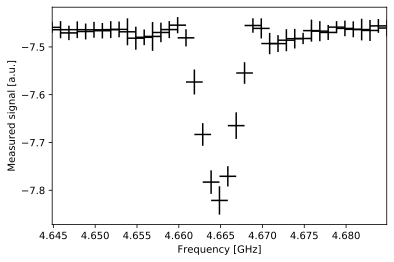

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.errorbar(frequencies_GHz, np.real(sweep_values_avg), yerr=sweep_values_uncert,xerr=np.repeat(0.001,41), fmt=' ', color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [19]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params,sigma):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params,sigma)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [20]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values_avg), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [-.4, 4.684864244429819, 1, -7.5] # initial parameters for curve_fit
                                ,sigma=sweep_values_uncert)

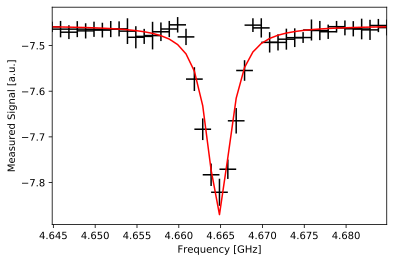

<Figure size 432x288 with 0 Axes>

In [21]:
plt.errorbar(frequencies_GHz, np.real(sweep_values_avg), yerr=sweep_values_uncert,xerr=np.repeat(0.001,41), fmt=' ', color='black') # plot real part of sweep values
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig("res_freq_err.png",bbox_inches='tight')

In [22]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 4.66486 GHz to 4.66478 GHz.


# Part 2. Calibrating and using a $\pi$ pulse <a id="calib"></a>
## A. Calibrating $\pi$ pulses using a Rabi experiment <a id="rabi"></a>

<img src="https://github.com/aasfaw/qiskit-intros/blob/master/zero_to_one_X180.png?raw=true">


In [23]:
# This experiment uses these values from the previous experiment:
    # `qubit`,
    # `measure`, and
    # `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 60

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.4

drive_samples = 1024
drive_sigma = 128
drive_amps = np.linspace(0.05, 0.5, num_rabi_points)

In [24]:
print(drive_samples)

1024


In [25]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.
rabi_schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule += rabi_pulse(drive_chan)
    # Reuse the measure instruction from the frequency sweep experiment
    this_schedule += measure << this_schedule.duration
    rabi_schedules.append(this_schedule)

/home/maziar/anaconda3/envs/Qiskitenv/lib/python3.7/site-packages/qiskit/pulse/pulse_lib/sample_pulse.py:152: DeprecationWarning: Calling `SamplePulse` with a channel is deprecated. Instantiate the new `Play` instruction directly with a pulse and a channel. In this case, please use: `Play(SamplePulse(samples), DriveChannel(0))`.
  DeprecationWarning)
/home/maziar/anaconda3/envs/Qiskitenv/lib/python3.7/site-packages/qiskit/pulse/pulse_lib/sample_pulse.py:152: DeprecationWarning: Calling `SamplePulse` with a channel is deprecated. Instantiate the new `Play` instruction directly with a pulse and a channel. In this case, please use: `Play(SamplePulse(samples), DriveChannel(0))`.
  DeprecationWarning)
/home/maziar/anaconda3/envs/Qiskitenv/lib/python3.7/site-packages/qiskit/pulse/pulse_lib/sample_pulse.py:152: DeprecationWarning: Calling `SamplePulse` with a channel is deprecated. Instantiate the new `Play` instruction directly with a pulse and a channel. In this case, please use: `Play(Samp

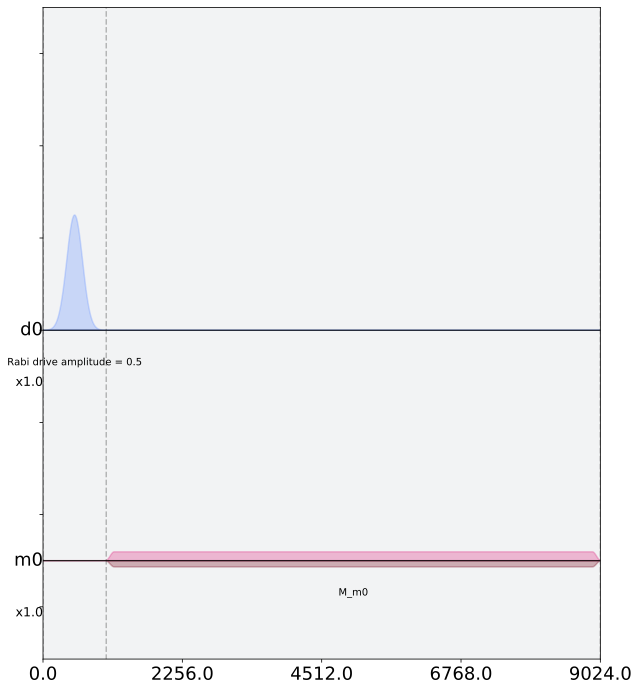

In [26]:
rabi_schedules[-1].draw(channels=[drive_chan, meas_chan], label=True, scaling=1.0)

In [27]:
# Assemble the schedules into a Qobj
num_shots_per_point = 4098

rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: rough_qubit_frequency}]
                                                * num_rabi_points)

In [96]:
# print(job.job_id())
job = backend.run(rabi_experiment_program)
job_monitor(job)

Job Status: job has successfully run


In [97]:
rabi_results = job.result(timeout=120)

In [98]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

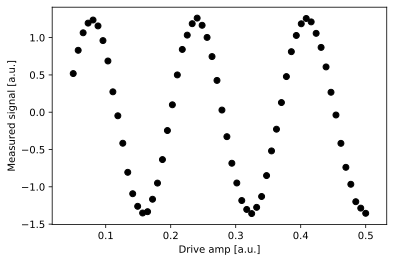

In [99]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit]*scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

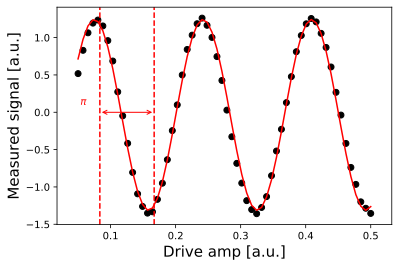

In [102]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [1, 0.1, 0.2, 0.2])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

We repeat this experiment 10 times as well to get an uncertainty:

In [195]:
#I want to repeat this 10 times to get an estimate on the error bars. 

rabi_job_ids=[]
rabi_job_results=[]
for i in range(10):
    rabi_job = backend.run(rabi_experiment_program)
    rabi_job_id= rabi_job.job_id()
    rabi_job_ids.append(rabi_job_id)
    print(rabi_job_id,job_monitor(rabi_job))
    rabi_result=rabi_job.result(timeout=120)
    rabi_job_results.append(rabi_result)

Job Status: job has successfully run
5eb84b3574bcc30018509c7b None
Job Status: job has successfully run
5eb84c926497240018566f2b None
Job Status: job has successfully run
5eb84db95a274d0018fdd36b None
Job Status: job has successfully run
5eb84ee55a274d0018fdd372 None
Job Status: job has successfully run
5eb850192a7ca10018275561 None
Job Status: job has successfully run
5eb851514be3f800197ddc7f None
Job Status: job has successfully run
5eb852834be3f800197ddc86 None
Job Status: job has successfully run
5eb853c32a7ca10018275577 None
Job Status: job has successfully run
5eb8551874bcc30018509cb8 None
Job Status: job has successfully run
5eb85698774a3c0018a08ab8 None


In [28]:
job_ids=[]
job_id=0
job_ids= ['5eb84b3574bcc30018509c7b',
'5eb84c926497240018566f2b' ,
'5eb84db95a274d0018fdd36b' ,
'5eb84ee55a274d0018fdd372' ,
'5eb850192a7ca10018275561' ,
'5eb851514be3f800197ddc7f' ,
'5eb852834be3f800197ddc86',
'5eb853c32a7ca10018275577',
'5eb8551874bcc30018509cb8' ,
'5eb85698774a3c0018a08ab8' ]

rabi_job_results=[]
for job_id in job_ids:
    rabi_job = backend.retrieve_job(job_id)
    rabi_result=rabi_job.result(timeout=120)
    rabi_job_results.append(rabi_result)
    

In [29]:
rabi_values_dic={}
for indx, rabi_result in enumerate(rabi_job_results):
    rabi_values = []
    for i in range(len(rabi_result.results)):
        # Get the results from the ith experiment
        rabi_res = rabi_result.get_memory(i)*scale_factor
        # Get the results for `qubit` from this experiment
        rabi_values.append(rabi_res[qubit])
    rabi_values_dic[indx]=rabi_values

In [30]:
import statistics #for standard deviation

rabi_values_avg= []
rabi_values_uncert= []

for j in range(len(rabi_values_dic[0])):
    list=[]   
    for i in range(10):
        list.append(rabi_values_dic[i][j])
    rabi_values_avg.append(sum(list)/len(list))
    rabi_values_uncert.append(statistics.pstdev(np.real(list)))
    

In [31]:
len(np.repeat(0.0075,61) )

61

In [32]:
import xlsxwriter

workbook = xlsxwriter.Workbook('rabi_data.xlsx')
worksheet = workbook.add_worksheet()
bold = workbook.add_format({'bold': 1})

headings=['x','y', 'simgax', 'sigmay']

worksheet.write_row('A1',headings,bold)
worksheet.write_column('A2',drive_amps)
worksheet.write_column('B2',np.real(rabi_values_avg))
worksheet.write_column('C2',np.repeat(0.0075,60))
worksheet.write_column('D2',rabi_values_uncert)

workbook.close() 

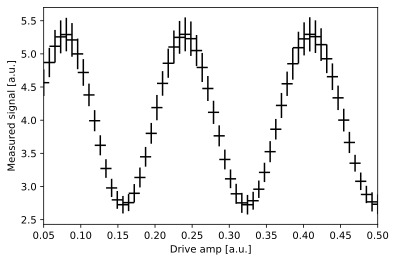

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.errorbar(drive_amps, np.real(rabi_values_avg), yerr=rabi_values_uncert,xerr=np.repeat(0.0075,60), fmt=' ', color='black') # plot real part of sweep values
plt.xlim([min(drive_amps), max(drive_amps)])
plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [34]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [1, 0.1, 0.2, 0.2],sigma= rabi_values_uncert)

/home/maziar/anaconda3/envs/Qiskitenv/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


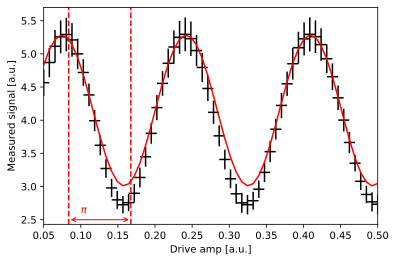

<Figure size 432x288 with 0 Axes>

In [35]:
plt.errorbar(drive_amps, np.real(rabi_values_avg), yerr=rabi_values_uncert,xerr=np.repeat(0.0075,60), fmt=' ', color='black') # plot real part of sweep values
plt.plot(drive_amps, y_fit, color='red')

plt.xlim([min(drive_amps), max(drive_amps)])
plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")


drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 2.5), xytext=(drive_period/2,2.5), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(0.1, 2.6), color='red')


rabi_fig = plt.gcf()
plt.show()
plt.draw()
rabi_fig.savefig("rabi_fig.png",bbox_inches='tight')

In [36]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.08371664676612943


### Our $\pi$ pulse!
Let's define our pulse, with the amplitude we just found, so we can use it in later experiments.

In [37]:
pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp, 
                              sigma=drive_sigma,
                              name='pi_pulse')

## B. Determining 0 vs 1 <a id="zerovone"></a>

In [38]:
# Create two schedules

# Ground state schedule
gnd_schedule = pulse.Schedule(name="ground state")
gnd_schedule += measure

# Excited state schedule
exc_schedule = pulse.Schedule(name="excited state")
exc_schedule += pi_pulse(drive_chan)  # We found this in Part 2A above
exc_schedule += measure << exc_schedule.duration

/home/maziar/anaconda3/envs/Qiskitenv/lib/python3.7/site-packages/qiskit/pulse/pulse_lib/sample_pulse.py:152: DeprecationWarning: Calling `SamplePulse` with a channel is deprecated. Instantiate the new `Play` instruction directly with a pulse and a channel. In this case, please use: `Play(SamplePulse(samples), DriveChannel(0))`.
  DeprecationWarning)


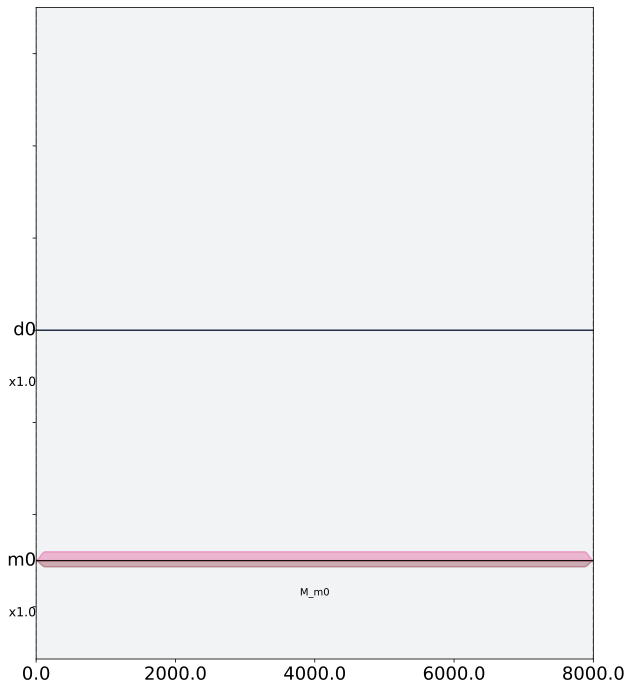

In [39]:
gnd_schedule.draw(channels=[drive_chan, meas_chan], label=True, scaling=1.0)

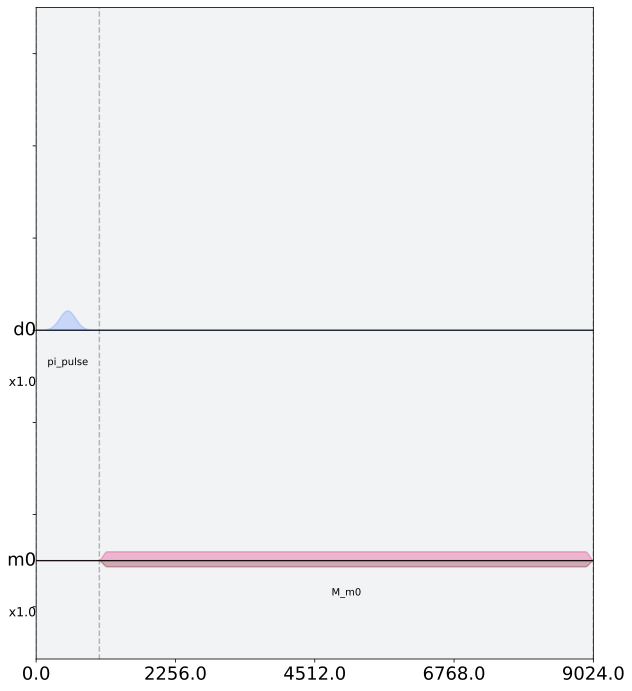

In [40]:
exc_schedule.draw(channels=[drive_chan, meas_chan], label=True, scaling=1.0)

In [41]:
# Execution settings
num_shots = 8192

gnd_exc_program = assemble([gnd_schedule, exc_schedule],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=num_shots,
                           schedule_los=[{drive_chan: rough_qubit_frequency}] * 2)

In [43]:
from qiskit.tools.monitor import job_monitor
job = backend.run(gnd_exc_program)
print(job.job_id())
job_monitor(job)

5ebd63a0362d5b001a215698
Job Status: job has successfully run


In [44]:
gnd_exc_results = job.result(timeout=120)

Now that we have the results, we can visualize the two populations which we have prepared on a simple scatter plot, showing results from the ground state program in blue and results from the excited state preparation program in red. Note: If the populations irregularly shaped (not approximtely circular), try re-running the notebook.

In [46]:
gnd_results = gnd_exc_results.get_memory(0)[:, qubit]*scale_factor
exc_results = gnd_exc_results.get_memory(1)[:, qubit]*scale_factor

plt.figure(figsize=[4,4])
# Plot all the results
# All results from the gnd_schedule are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the exc_schedule are plotted in red
plt.scatter(np.real(exc_results), np.imag(exc_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_exc = np.mean(exc_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)



discr_fig = plt.gcf()
plt.show()
plt.draw()
discr_fig.savefig("discr_fig.png",bbox_inches='tight')

<Figure size 432x288 with 0 Axes>